# 🚀 Model Deployment
This notebook implements the **final deployment pipeline** for the used car price prediction model. The deployment process involves:

- **🎯 Model**: Ridge Regression with optimal hyperparameters (α = 1.0)
- **✨ Feature Engineering**: Preprocessing with polynomial features, interactions, and one-hot encoding
- **🔍 Feature Selection**: 287 optimally selected features from Lasso regularization
- **🏭 Production Ready**: Full pipeline trained on 312,846 vehicle records for serving (100% of the dataset)

The model is trained on the complete dataset using the optimal feature set pre-calculated in `evaluation.ipynb` through SelectFromModel with Lasso regularization.  
⚠️ Check the last section to **test the model with your own data** ⚠️

---
## 1. 📂 Data Loading & Setup
Load the complete preprocessed vehicle dataset for final model training. Unlike the evaluation phase, we use **all available data** to maximize model performance for production deployment.
You will find the same code as in previous notebooks, except for the fact that we didn't use `train_test_split` since we are using 100% of dataset.

In [1]:
# Standard library imports
import warnings
import importlib

# Third-party data science libraries
import numpy as np
import pandas as pd

# ── Optional Intel® Extension for Scikit-learn* ────────────────────────────────
try:
    # Fast check without importing the whole module
    if importlib.util.find_spec("sklearnex") is not None:
        from sklearnex import patch_sklearn

        patch_sklearn()              # ⚡ swaps many sklearn algos for DAAL-backed ones
        print("[sklearnex] Intel-optimized algorithms enabled")
    else:
        raise ModuleNotFoundError

except Exception as e:
    # Any problem: missing library, version clash, patch failure, etc.
    warnings.warn(
        f"[sklearnex] Extension not active ({e.__class__.__name__}: {e}). "
        "Falling back to stock scikit-learn.",
        RuntimeWarning,
    )

# Scikit-learn imports
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures

# Configuration
warnings.filterwarnings('ignore')

[sklearnex] Intel-optimized algorithms enabled


Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [2]:
# Load the processed vehicles dataset
df = pd.read_csv('../data/vehicles_processed.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()

Dataset shape: (312846, 14)
Columns: ['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition', 'fuel', 'odometer', 'title_status', 'transmission', 'type', 'paint_color', 'state']


,id,region,price,year,manufacturer,model,condition,fuel,odometer,title_status,transmission,type,paint_color,state
0,7316814884,other_al,33590,2014.0,gmc,other_gmc,good,gas,57923.0,clean,other,pickup,white,al
1,7316814758,other_al,22590,2010.0,chevrolet,silverado 1500,good,gas,71229.0,clean,other,pickup,blue,al
2,7316814989,other_al,39590,2020.0,chevrolet,other_chevrolet,good,gas,19160.0,clean,other,pickup,red,al
3,7316743432,other_al,30990,2017.0,toyota,other_toyota,good,gas,41124.0,clean,other,pickup,red,al
4,7316356412,other_al,15000,2013.0,ford,other_ford,excellent,gas,128000.0,clean,automatic,truck,black,al


In [3]:
# Split into X and Y
# Identify categorical and numerical columns
categorical_cols = ['region', 'manufacturer', 'model', 'condition', 'fuel',  
                   'title_status', 'transmission', 'type', 'paint_color', 'state']
numerical_cols =   ['year', 'odometer']

# Prepare features and target
X = df[categorical_cols + numerical_cols]
y = df['price']

print(f"Features shape: {X.shape}")
print(f"Target shape:   {y.shape}")
print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns:   {numerical_cols}")

Features shape: (312846, 12)
Target shape:   (312846,)
Categorical columns: ['region', 'manufacturer', 'model', 'condition', 'fuel', 'title_status', 'transmission', 'type', 'paint_color', 'state']
Numerical columns:   ['year', 'odometer']


In [4]:
# Import feature engineering helpers
from utils import age_transformer, age_odometer_transformer

# Create preprocessing pipelines
age_pipeline = Pipeline([
    ('to_age',  age_transformer),                                    # year → age
    ('poly',    PolynomialFeatures(degree=2, include_bias=False)),   # add age²
    ('scaler',  StandardScaler())                                    # scale age, age²
])

odometer_pipeline = Pipeline([
    ('poly',    PolynomialFeatures(degree=2, include_bias=False)),   # add odo²
    ('scaler',  StandardScaler())                                    # scale odo, odo²
])

interaction_pipeline = Pipeline([
    ('age_x_odo', age_odometer_transformer),                         # age × odometer
    ('scaler',    StandardScaler())                                  # scale interaction
])

# Create the main preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat',      OneHotEncoder(drop='first',
                                   sparse_output=False,
                                   handle_unknown='ignore'),
                     categorical_cols),
        ('age',      age_pipeline,        ['year']),                 # year → age, age²
        ('odometer', odometer_pipeline,   ['odometer']),             # odo, odo²
        ('ageXodo',  interaction_pipeline, ['year', 'odometer'])     # age×odo
    ],
    remainder='drop',
    verbose_feature_names_out=False                                  # cleaner column names
)

---
## 2. 🎯 Feature Selection Pipeline

### 🔍 Optimal Feature Subset Loading
Loading the **287 carefully selected features** identified through Lasso regularization in the evaluation phase. This feature selection process eliminates redundant variables while preserving predictive power.

### 📋 Selection Process
- **🧮 Method**: SelectFromModel with Lasso regularization
- **📊 Source**: `../data/lasso_selected_features.csv`
- **🎛️ Result**: 287 features from 374 total engineered features
- **⚡ Benefit**: Faster inference

In [8]:
# Load desired feature names from CSV
df_feats  = pd.read_csv("../data/lasso_selected_features.csv")
desired_cols = df_feats["Feature"].astype(str).str.strip().tolist()
print(f"# of features loaded: {len(desired_cols)}")

# of features loaded: 287


---
## 3. 🏗️ Production Model Training

### 🎯 Final Model Pipeline
Training the **production-ready Ridge Regression model** on the complete dataset using optimally selected features. This represents the final model that will be deployed for price predictions.

### ⚙️ Model Configuration
- **🤖 Algorithm**: Ridge Regression (L2 regularization)
- **🎛️ Hyperparameter**: α = 1.0 (optimal value from grid search)
- **🔧 Random State**: 42 (reproducible results)
- **📊 Training Data**: Full 312,846 vehicle records

> **🚀 Ready for Deployment**: This model is now trained on the full dataset and ready for production serving with consistent preprocessing and feature selection.

In [7]:
# Tell scikit-learn to keep the column names (needs sklearn ≥ 1.2)
preprocessor.set_output(transform='pandas')

selector = ColumnTransformer(
    [("keep", "passthrough", desired_cols)],
    remainder="drop",
    verbose_feature_names_out=False,
)

## Training final model with feature selection on full training data
print("Training Ridge model with selected features on full training data...")

# Create pipeline with feature selection
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector',     selector),  # Select only desired features
    ('model', Ridge(alpha=1.0, random_state=42))
])

# Fit on full training data
final_pipeline.fit(X, y)

# Get the final feature count after selection
X_selected = final_pipeline.named_steps['selector'].transform(
    final_pipeline.named_steps['preprocessor'].transform(X)
)
print(f"Final feature matrix shape: {X_selected.shape}")

# Show some basic model info
ridge_model = final_pipeline.named_steps['model']
print(f"Ridge alpha: {ridge_model.alpha}")
print(f"Model coefficients shape: {ridge_model.coef_.shape}")

# Calculate training score
train_score = final_pipeline.score(X, y)
print(f"Training R² score: {train_score:.4f}")

Training Ridge model with selected features on full training data...
Final feature matrix shape: (312846, 287)
Ridge alpha: 1.0
Model coefficients shape: (287,)
Training R² score: 0.6444


---
## 4. 🌐 Model Serving & Deployment

### ✅ Model Ready for Production
Our **Ridge Regression model** is now fully trained and ready for serving! The `final_pipeline` object contains the complete preprocessing and prediction pipeline.

Below you'll find **prediction examples** demonstrating how the model performs on various vehicle configurations, including comparisons with actual prices and error analysis.

In [9]:
# Get 2 random samples from the training dataset for comparison
sample_indices = [1000, 5000]  # Fixed indices for reproducibility
sample_data = X.iloc[sample_indices].copy()
actual_prices = y.iloc[sample_indices].values

# Create a custom example - 2018 Toyota Camry in excellent condition
custom_example = pd.DataFrame({
    'region': ['seattle'],
    'manufacturer': ['toyota'],
    'model': ['camry'],
    'condition': ['excellent'],
    'fuel': ['gas'],
    'title_status': ['clean'],
    'transmission': ['automatic'],
    'type': ['sedan'],
    'paint_color': ['white'],
    'state': ['wa'],
    'year': [2018.0],
    'odometer': [45000.0]
})

# Combine all examples
all_examples = pd.concat([sample_data, custom_example], ignore_index=True)

# Make predictions
predictions = final_pipeline.predict(all_examples)

# Display results
print("🚗 PREDICTION EXAMPLES")
print("=" * 50)

for i, (idx, row) in enumerate(all_examples.iterrows()):
    if i < 2:  # Real examples
        actual = actual_prices[i]
        error = predictions[i] - actual
        error_pct = (error / actual) * 100
        print(f"\n📊 Example {i+1} (Real Data - Index {sample_indices[i]}):")
        print(f"   Vehicle: {row['year']:.0f} {row['manufacturer'].title()} {row['model'].title()}")
        print(f"   Condition: {row['condition'].title()} | Odometer: {row['odometer']:,.0f} miles")
        print(f"   Actual Price:    ${actual:,.0f}")
        print(f"   Predicted Price: ${predictions[i]:,.0f}")
        print(f"   Error:           ${error:+,.0f} ({error_pct:+.1f}%)")
    else:  # Custom example
        print(f"\n🔧 Example {i+1} (Custom Configuration):")
        print(f"   Vehicle: {row['year']:.0f} {row['manufacturer'].title()} {row['model'].title()}")
        print(f"   Condition: {row['condition'].title()} | Odometer: {row['odometer']:,.0f} miles")
        print(f"   Location: {row['region'].title()}, {row['state'].upper()}")
        print(f"   Predicted Price: ${predictions[i]:,.0f}")

print("\n" + "=" * 50)


🚗 PREDICTION EXAMPLES

📊 Example 1 (Real Data - Index 1000):
   Vehicle: 2016 Ford Mustang
   Condition: Missing | Odometer: 36,772 miles
   Actual Price:    $29,500
   Predicted Price: $25,080
   Error:           $-4,420 (-15.0%)

📊 Example 2 (Real Data - Index 5000):
   Vehicle: 2019 Jeep Grand Cherokee
   Condition: Missing | Odometer: 2,650 miles
   Actual Price:    $36,194
   Predicted Price: $30,890
   Error:           $-5,304 (-14.7%)

🔧 Example 3 (Custom Configuration):
   Vehicle: 2018 Toyota Camry
   Condition: Excellent | Odometer: 45,000 miles
   Location: Seattle, WA
   Predicted Price: $22,270



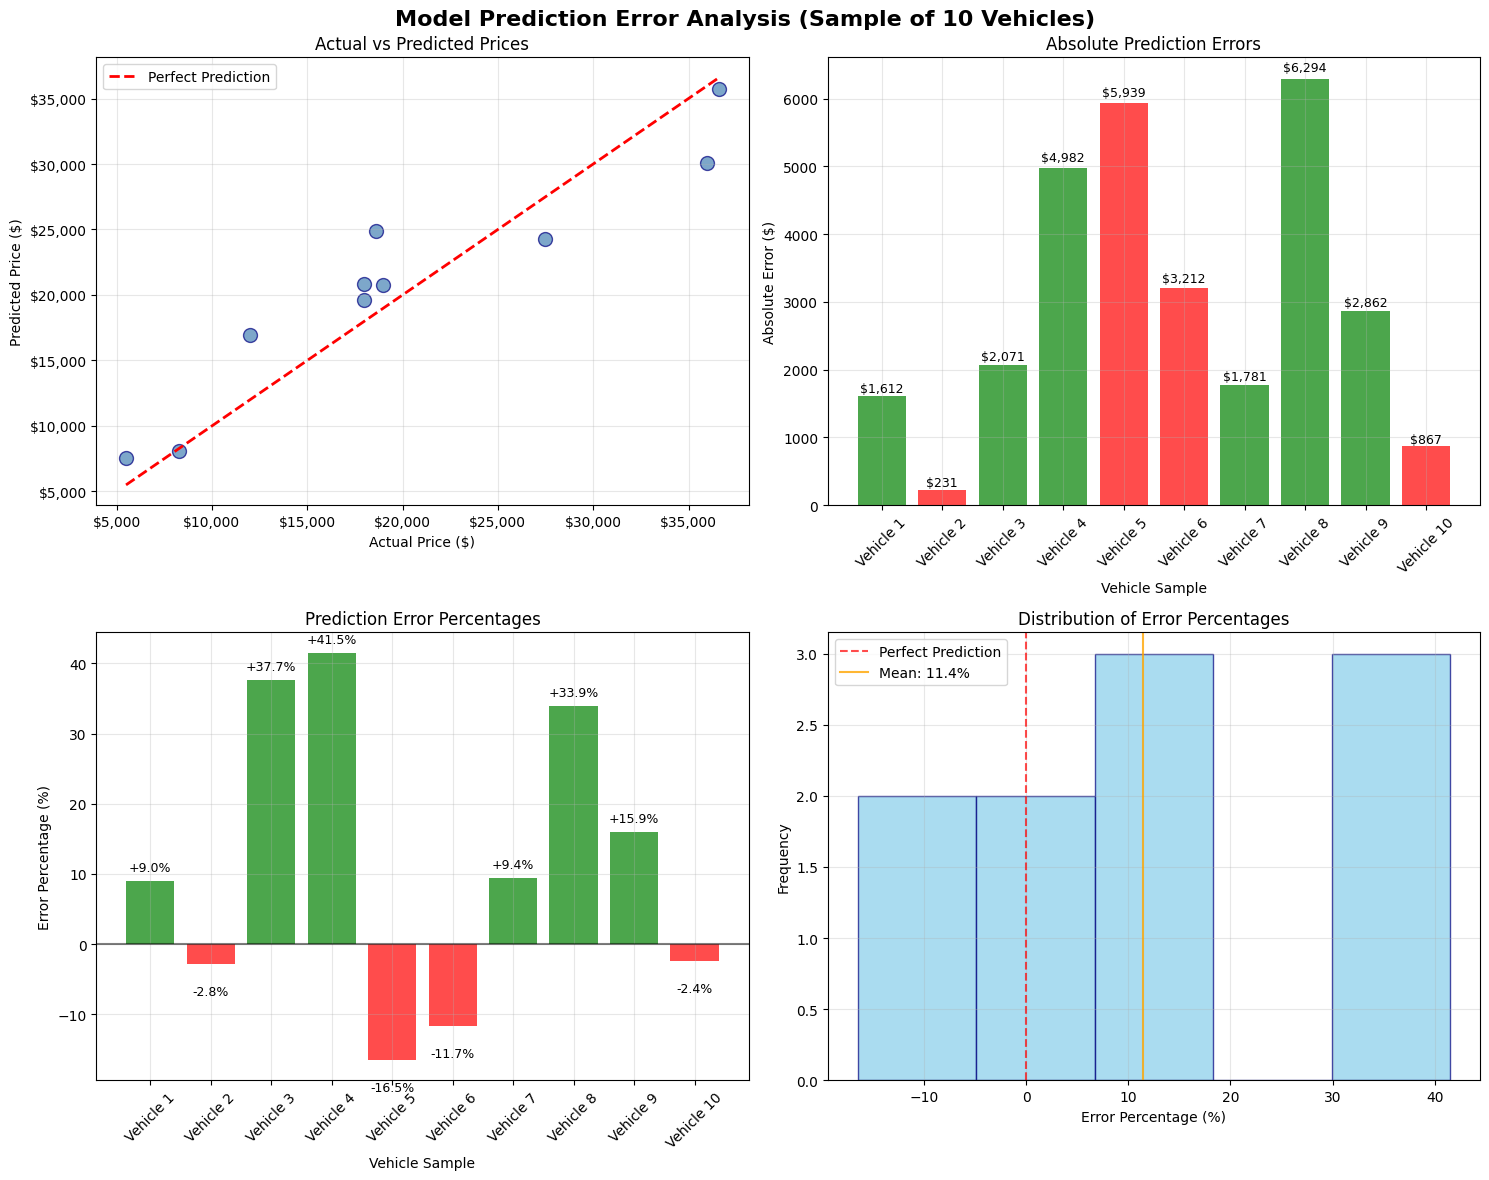

ERROR ANALYSIS SUMMARY
Sample Size:              10 vehicles
Mean Absolute Error:      $2,985
Mean Absolute % Error:    18.1%
Root Mean Square Error:   $3,593
Max Overestimate:         $6,294 (+41.5%)
Max Underestimate:        $-5,939 (-16.5%)

🔍 DETAILED RESULTS
----------------------------------------------------------------------
Vehicle  Actual     Predicted  Error      Error % 
----------------------------------------------------------------------
1        $17,995    $19,607    $+1,612      +9.0%
2        $8,300     $8,069     $-231        -2.8%
3        $5,500     $7,571     $+2,071     +37.7%
4        $11,999    $16,981    $+4,982     +41.5%
5        $35,980    $30,041    $-5,939     -16.5%
6        $27,495    $24,283    $-3,212     -11.7%
7        $18,995    $20,776    $+1,781      +9.4%
8        $18,590    $24,884    $+6,294     +33.9%
9        $17,995    $20,857    $+2,862     +15.9%
10       $36,590    $35,723    $-867        -2.4%


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Sample 10 random vehicles from the training dataset
np.random.seed(60)  # For reproducibility
sample_size = 10
random_indices = np.random.choice(len(X), size=sample_size, replace=False)

# Get sample data
X_sample = X.iloc[random_indices]
y_actual = y.iloc[random_indices].values

# Make predictions
y_pred = final_pipeline.predict(X_sample)

# Calculate errors
errors = y_pred - y_actual
error_percentages = (errors / y_actual) * 100

# Create a comprehensive chart
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Prediction Error Analysis (Sample of 10 Vehicles)', fontsize=16, fontweight='bold')

# 1. Actual vs Predicted Prices
ax1.scatter(y_actual, y_pred, alpha=0.7, s=100, color='steelblue', edgecolors='navy')
ax1.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Price ($)')
ax1.set_ylabel('Predicted Price ($)')
ax1.set_title('Actual vs Predicted Prices')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Format axes as currency
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# 2. Absolute Errors
vehicle_labels = [f"Vehicle {i+1}" for i in range(sample_size)]
colors = ['red' if e < 0 else 'green' for e in errors]
bars = ax2.bar(vehicle_labels, np.abs(errors), color=colors, alpha=0.7)
ax2.set_xlabel('Vehicle Sample')
ax2.set_ylabel('Absolute Error ($)')
ax2.set_title('Absolute Prediction Errors')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar, error in zip(bars, errors):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'${height:,.0f}', ha='center', va='bottom', fontsize=9)

# 3. Error Percentages
ax3.bar(vehicle_labels, error_percentages, color=colors, alpha=0.7)
ax3.set_xlabel('Vehicle Sample')
ax3.set_ylabel('Error Percentage (%)')
ax3.set_title('Prediction Error Percentages')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Add value labels
for i, pct in enumerate(error_percentages):
    ax3.text(i, pct + (1 if pct >= 0 else -3), f'{pct:+.1f}%', 
             ha='center', va='bottom' if pct >= 0 else 'top', fontsize=9)

# 4. Error Distribution
ax4.hist(error_percentages, bins=5, alpha=0.7, color='skyblue', edgecolor='navy')
ax4.set_xlabel('Error Percentage (%)')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of Error Percentages')
ax4.grid(True, alpha=0.3)
ax4.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Perfect Prediction')
ax4.axvline(x=np.mean(error_percentages), color='orange', linestyle='-', alpha=0.8, label=f'Mean: {np.mean(error_percentages):.1f}%')
ax4.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("ERROR ANALYSIS SUMMARY")
print("=" * 40)
print(f"Sample Size:              {sample_size} vehicles")
print(f"Mean Absolute Error:      ${np.mean(np.abs(errors)):,.0f}")
print(f"Mean Absolute % Error:    {np.mean(np.abs(error_percentages)):.1f}%")
print(f"Root Mean Square Error:   ${np.sqrt(np.mean(errors**2)):,.0f}")
print(f"Max Overestimate:         ${np.max(errors):,.0f} ({np.max(error_percentages):+.1f}%)")
print(f"Max Underestimate:        ${np.min(errors):,.0f} ({np.min(error_percentages):+.1f}%)")

# Show individual results
print(f"\n🔍 DETAILED RESULTS")
print("-" * 70)
print(f"{'Vehicle':<8} {'Actual':<10} {'Predicted':<10} {'Error':<10} {'Error %':<8}")
print("-" * 70)
for i in range(sample_size):
    print(f"{i+1:<8} ${y_actual[i]:<9,.0f} ${y_pred[i]:<9,.0f} ${errors[i]:<+9,.0f} {error_percentages[i]:+6.1f}%")


---
## 🔡 5. Try your own data

In [24]:
## Try your own vehicle configuration

custom_example2 = pd.DataFrame({
    'region': ['san francisco'],
    'manufacturer': ['chevrolet'],
    'model': ['impala'],
    'condition': ['excellent'],
    'fuel': ['gas'],
    'title_status': ['clean'],
    'transmission': ['automatic'],
    'type': ['sedan'],
    'paint_color': ['black'],
    'state': ['ca'],
    'year': [2015.0],
    'odometer': [25000.0]
})

predictions2 = final_pipeline.predict(custom_example2)
print(f"Predicted price: ${predictions2[0]:,.0f}")

Predicted price: $14,497


---
## 🎁 Bonus: if you want a prediction interval
This cell takes a long time to execute even in fast computer (took 4 mins in Intel 13th-gen 13600KS with Intel optimized sklearn libraries)

In [26]:
from sklearn.base import clone
import numpy as np

def bootstrap_pi(pipeline, X_train, y_train, X_new, n_boot=1000,
                 ci_level=0.90, random_state=42):
    """
    Returns (lower, upper) bounds of a central CI for a single row X_new.
    """
    rng = np.random.RandomState(random_state)
    preds = np.empty(n_boot)

    for b in range(n_boot):
        # sample with replacement
        sample_idx = rng.choice(len(X_train), size=len(X_train), replace=True)
        X_b = X_train.iloc[sample_idx]
        y_b = y_train.iloc[sample_idx]

        # clone & refit the **entire** pipeline
        pipe_b = clone(pipeline)
        pipe_b.fit(X_b, y_b)

        # store prediction for the new sample
        preds[b] = pipe_b.predict(X_new)[0]

    # central (1-α) interval
    alpha = 1 - ci_level
    lower = np.percentile(preds, 100 * alpha / 2)
    upper = np.percentile(preds, 100 * (1 - alpha / 2))
    return lower, upper, preds.mean()

# ------------------------ usage ------------------------
lower, upper, mean_pred = bootstrap_pi(
    final_pipeline, X, y, custom_example2,
    n_boot=100, ci_level=0.90
)

print(f"Point prediction  : ${mean_pred:,.0f}")
print(f"90 % pred. interval: ${lower:,.0f} – ${upper:,.0f}")

Point prediction  : $14,524
90 % pred. interval: $14,226 – $14,836
